In [1]:
from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import process_fidelity
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel, errors

from qiskit.tools.visualization import plot_histogram

In [2]:
# CNOT matrix operator with qubit-0 as control and qubit-1 as target
cx_op = Operator([[1, 0, 0, 0],
                  [0, 0, 0, 1],
                  [0, 0, 1, 0],
                  [0, 1, 0, 0]])

# iSWAP matrix operator
iswap_op = Operator([[1, 0, 0, 0],
                     [0, 0, 1j, 0],
                     [0, 1j, 0, 0],
                     [0, 0, 0, 1]])

In [3]:
# CNOT in terms of iSWAP and single-qubit gates
cx_circ = QuantumCircuit(2)

# Add gates
cx_circ.sdg(1)
cx_circ.h(1)
cx_circ.sdg(0)
cx_circ.unitary(iswap_op, [0, 1], label='iswap')
cx_circ.sdg(0)
cx_circ.h(0)
cx_circ.sdg(0)
cx_circ.unitary(iswap_op, [0, 1], label='iswap')
cx_circ.s(1)

print(cx_circ)

        ┌─────┐     ┌──────────┐┌─────┐┌───┐┌─────┐┌──────────┐     
q_0: |0>┤ Sdg ├─────┤0         ├┤ Sdg ├┤ H ├┤ Sdg ├┤0         ├─────
        ├─────┤┌───┐│  unitary │└─────┘└───┘└─────┘│  unitary │┌───┐
q_1: |0>┤ Sdg ├┤ H ├┤1         ├───────────────────┤1         ├┤ S ├
        └─────┘└───┘└──────────┘                   └──────────┘└───┘


In [5]:

# Simulate the unitary for the circuit using Operator:
unitary = Operator(cx_circ)
print(unitary)

Operator([[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]], input_dims=(2, 2), output_dims=(2, 2))


In [6]:
fpro = process_fidelity(cx_op, unitary)
print("Process Fidelity = ", fpro)

Process Fidelity =  (0.9999999999999996+0j)


In [7]:
'unitary' in QasmSimulator().configuration().basis_gates

True

In [8]:
# Error parameters
param_q0 = 0.05  # damping parameter for qubit-0
param_q1 = 0.1   # damping parameter for qubit-1

# Construct the error
qerror_q0 = errors.amplitude_damping_error(param_q0)
qerror_q1 = errors.amplitude_damping_error(param_q1)
iswap_error = qerror_q1.tensor(qerror_q0)

# Build the noise model by adding the error to the "iswap" gate
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(iswap_error, 'iswap')

In [9]:
noise_model.add_basis_gates(['unitary'])
print(noise_model.basis_gates)

['cx', 'id', 'u3', 'unitary']


In [10]:

# Bell state circuit where iSWAPS should be inserted at barrier locations
bell_circ = QuantumCircuit(2, 2, name='bell')
bell_circ.h(0)
bell_circ = bell_circ + cx_circ 
bell_circ.measure([0,1], [0,1])
print(bell_circ)

         ┌───┐ ┌─────┐┌──────────┐┌─────┐┌───┐┌─────┐┌──────────┐     ┌─┐   
q_0: |0>─┤ H ├─┤ Sdg ├┤0         ├┤ Sdg ├┤ H ├┤ Sdg ├┤0         ├─────┤M├───
        ┌┴───┴┐└┬───┬┘│  unitary │└─────┘└───┘└─────┘│  unitary │┌───┐└╥┘┌─┐
q_1: |0>┤ Sdg ├─┤ H ├─┤1         ├───────────────────┤1         ├┤ S ├─╫─┤M├
        └─────┘ └───┘ └──────────┘                   └──────────┘└───┘ ║ └╥┘
 c_0: 0 ═══════════════════════════════════════════════════════════════╩══╬═
                                                                          ║ 
 c_1: 0 ══════════════════════════════════════════════════════════════════╩═
                                                                            


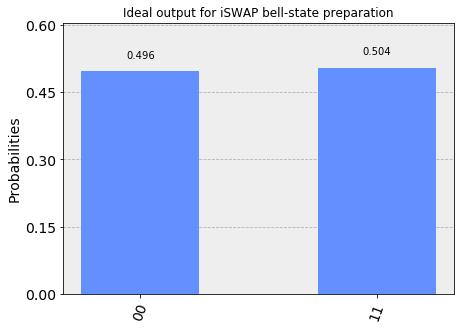

In [11]:
# Execute on the simulator without noise
job = execute(bell_circ, QasmSimulator(),
              basis_gates=noise_model.basis_gates)
ideal_result = job.result()
ideal_counts = ideal_result.get_counts(bell_circ)
plot_histogram(ideal_counts, title='Ideal output for iSWAP bell-state preparation')

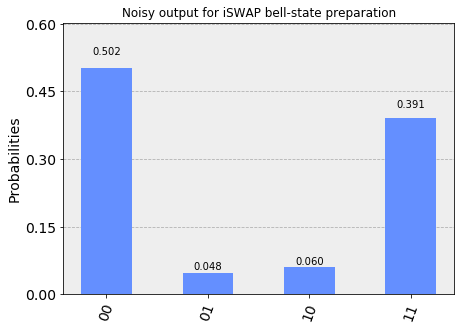

In [12]:
# Execute on the simulator without noise
job = execute(bell_circ, QasmSimulator(),
              basis_gates=noise_model.basis_gates,
              noise_model=noise_model)
noise_result = job.result()
noise_counts = noise_result.get_counts(bell_circ)
plot_histogram(noise_counts, title='Noisy output for iSWAP bell-state preparation')

In [13]:

import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

In [14]:
# -*- coding: utf-8 -*-

# This code is part of Qiskit.
#
# (C) Copyright IBM 2017.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""
Quantum teleportation example.

Note: if you have only cloned the Qiskit repository but not
used `pip install`, the examples only work from the root directory.
"""

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import BasicAer
from qiskit import execute

###############################################################
# Set the backend name and coupling map.
###############################################################
coupling_map = [[0, 1], [0, 2], [1, 2], [3, 2], [3, 4], [4, 2]]
backend = BasicAer.get_backend("qasm_simulator")

###############################################################
# Make a quantum program for quantum teleportation.
###############################################################
q = QuantumRegister(3, "q")
c0 = ClassicalRegister(1, "c0")
c1 = ClassicalRegister(1, "c1")
c2 = ClassicalRegister(1, "c2")
qc = QuantumCircuit(q, c0, c1, c2, name="teleport")

# Prepare an initial state
qc.u3(0.3, 0.2, 0.1, q[0])

# Prepare a Bell pair
qc.h(q[1])
qc.cx(q[1], q[2])

# Barrier following state preparation
qc.barrier(q)

# Measure in the Bell basis
qc.cx(q[0], q[1])
qc.h(q[0])
qc.measure(q[0], c0[0])
qc.measure(q[1], c1[0])

# Apply a correction
qc.barrier(q)
qc.z(q[2]).c_if(c0, 1)
qc.x(q[2]).c_if(c1, 1)
qc.measure(q[2], c2[0])

###############################################################
# Execute.
# Experiment does not support feedback, so we use the simulator
###############################################################

# First version: not mapped
initial_layout = {q[0]: 0,
                  q[1]: 1,
                  q[2]: 2}
job = execute(qc, backend=backend, coupling_map=None, shots=1024,
              initial_layout=initial_layout)

result = job.result()
print(result.get_counts(qc))

# Second version: mapped to 2x8 array coupling graph
job = execute(qc, backend=backend, coupling_map=coupling_map, shots=1024,
              initial_layout=initial_layout)
result = job.result()
print(result.get_counts(qc))
# Both versions should give the same distribution

{'0 0 1': 246, '0 0 0': 239, '0 1 1': 263, '1 1 0': 5, '1 1 1': 10, '0 1 0': 253, '1 0 0': 6, '1 0 1': 2}
{'0 0 1': 246, '0 0 0': 239, '0 1 1': 263, '1 1 0': 5, '1 1 1': 10, '0 1 0': 253, '1 0 0': 6, '1 0 1': 2}


In [15]:
# -*- coding: utf-8 -*-

# This code is part of Qiskit.
#
# (C) Copyright IBM 2018, 2019.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""
breast cancer dataset
"""

import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
try:
    import matplotlib.pyplot as plt
    HAS_MATPLOTLIB = True
except ImportError:
    HAS_MATPLOTLIB = False


def breast_cancer(training_size, test_size, n, plot_data=False):
    """ returns breast cancer dataset """
    class_labels = [r'A', r'B']
    data, target = datasets.load_breast_cancer(True)
    sample_train, sample_test, label_train, label_test = \
        train_test_split(data, target, test_size=0.3, random_state=12)

    # Now we standardize for gaussian around 0 with unit variance
    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)

    # Now reduce number of features to number of qubits
    pca = PCA(n_components=n).fit(sample_train)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)

    # Scale to the range (-1,+1)
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)

    # Pick training size number of samples from each distro
    training_input = {key: (sample_train[label_train == k, :])[:training_size]
                      for k, key in enumerate(class_labels)}
    test_input = {key: (sample_test[label_test == k, :])[:test_size]
                  for k, key in enumerate(class_labels)}

    if plot_data:
        if not HAS_MATPLOTLIB:
            raise NameError('Matplotlib not installed. Plase install it before plotting')
        for k in range(0, 2):
            plt.scatter(sample_train[label_train == k, 0][:training_size],
                        sample_train[label_train == k, 1][:training_size])

        plt.title("PCA dim. reduced Breast cancer dataset")
        plt.show()

    return sample_train, training_input, test_input, class_labels